<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW2/blob/main/NLP_HW2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [73]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Bidirectional, LSTM, Input
from keras.models import Sequential

# Dataset

In [3]:
!gdown 1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
!gdown 1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
!gdown 1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
!gdown 1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50

Downloading...
From: https://drive.google.com/uc?id=1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
To: /content/UPC_2016_train.txt
100% 25.4M/25.4M [00:00<00:00, 159MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
To: /content/UPC_2016_val.txt
100% 5.47M/5.47M [00:00<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
To: /content/UPC_2016_test.txt
100% 5.48M/5.48M [00:00<00:00, 233MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50
To: /content/vectors.zip
100% 48.2M/48.2M [00:00<00:00, 147MB/s]


In [4]:
def read_dataset(filepath):
  file = open(filepath, "r")

  dataset = [[]]

  item_counter = 0
  end_line = False
  for line in file.readlines():
    line_splitted = line.split()
    if len(line_splitted) == 2:  
      token, tag = line_splitted
      
      dataset[-1].append((token, tag))
    else:
      dataset.append([])
      item_counter += 1

  return dataset[:-1]

In [5]:
train_dataset = read_dataset("/content/UPC_2016_train.txt")
valid_dataset = read_dataset("/content/UPC_2016_val.txt")
test_dataset = read_dataset("/content/UPC_2016_test.txt")

In [11]:
!unzip /content/vectors.zip

Archive:  /content/vectors.zip
replace vectors.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vectors.txt             


# Dataset Overview

In [30]:
print("train max length = ", max([len(data) for data in train_dataset]))
print("test max length = ", max([len(data) for data in test_dataset]))
print("valid max length = ", max([len(data) for data in valid_dataset]))

train max length =  734
test max length =  734
valid max length =  676


In [15]:
max_length = max([len(data) for data in train_dataset])

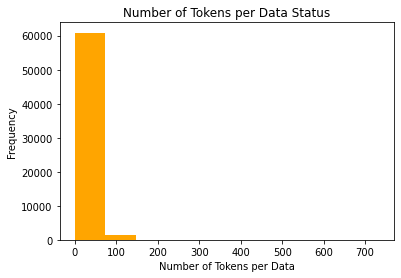

In [26]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([len(data) for data in train_dataset], color="orange")
plt.show()

In [46]:
print(f"Percent of Long-tail data = {sum([len(data)>128 for data in train_dataset]) * 100 / len(train_dataset)} %")

Percent of Long-tail data = 0.37896352675930217 %


# Split Long Data

In [47]:
max_length = 128

In [53]:
def split_long_data(dataset, max_length):
  new_dataset = []
  for data in dataset:
    number_new_data = math.ceil(len(data)/max_length)

    for i in range(number_new_data):
      new_dataset.append(data[i*max_length : min((i+1)*max_length, len(data))])

  return new_dataset

In [58]:
train_dataset = split_long_data(train_dataset, max_length)
test_dataset = split_long_data(test_dataset, max_length)
valid_dataset = split_long_data(valid_dataset, max_length)

# Tag to Index

In [12]:
all_tag = set()

for data in train_dataset:
  for item in data:
    tag = item[1]
    all_tag.add(tag)

In [13]:
tag2index = {tag:i+1 for i, tag in enumerate(all_tag)}
tag2index["PAD"] = 0

# Word to Vec 

In [14]:
file = open("/content/vectors.txt", "r")

word2vector = {}

for i, line in enumerate(file.readlines()):
  line_splitted = line.split()
  word = line_splitted[0]
  vector = np.array(line_splitted[1:], dtype="float")

  word2vector[word] = vector

# Digitalize & Padding

In [59]:
def preprocess(dataset, max_length):
  digitalized_dataset = []
  dataset_X = []
  dataset_y = []

  for data in dataset:
    dataset_X.append([])
    dataset_y.append([])

    for item in data:
      vector = word2vector.get(item[0], np.zeros(50))
      tag_index = tag2index[item[1]]
      dataset_X[-1].append(vector)
      dataset_y[-1].append(tag_index)

    for _ in range(max_length-len(dataset_y[-1])):
      dataset_y[-1].append(0)
      dataset_X[-1].append(np.zeros(50))

  return dataset_X, dataset_y

In [68]:
train_X, train_y = preprocess(train_dataset, max_length)
test_X, test_y = preprocess(test_dataset, max_length)
valid_X, valid_y = preprocess(valid_dataset, max_length)

# BiLSTM Model

In [ ]:
class BiLSTM(keras.model):
  def __init__(self, max_length, number_tags):
    super().__init()
    self.model = Sequential([
                             Input(input_shape=(max_length, 50)),
                             Bidirectional(LSTM(256, return_sequence=True)),
                             Dense(number_tags, activation="softmax")
    ])
  
  def call(self, inputs):
    return self.model(inputs)